In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from dynamic_routing_analysis import spike_utils, plot_utils
import dynamic_routing_analysis as dra
import os

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# load data
# regenerate_table=False
# all_data_loadpath=dra.SINGLE_UNIT_METRICS_PATH / "combined" / "all_data_plus_performance.pkl"
# all_data_loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"
# all_data_loadpath=r"D:\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"
all_data_loadpath='s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units_with_activity_metrics_exclude_instruction_trials.parquet'

# if regenerate_table:
#     savepath = dra.SINGLE_UNIT_METRICS_PATH / "combined"
#     stim_context_loadpath = dra.SINGLE_UNIT_METRICS_PATH
#     lick_loadpath = dra.SINGLE_UNIT_METRICS_PATH / "lick_modulation"
#     performance_loadpath = os.path.join(savepath,"performance_dict.pkl")
#     spike_utils.concat_single_unit_metrics_across_sessions(stim_context_loadpath=stim_context_loadpath,lick_loadpath=lick_loadpath,
#                                                            performance_loadpath=None,savepath=savepath)

# all_data = pd.read_pickle(all_data_loadpath)

all_data = pd.read_parquet(all_data_loadpath)

# #temp hack take first x characters of session id to match with dr_session_list
# all_data['session_id'] = all_data['session_id'].str.slice(0,17)

In [6]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

templeton_session_list=(
    session_table.filter(
    pl.col('project')=="Templeton",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    )['session_id'].to_list()
)

In [ ]:
#temp hack take first x characters of session id to match with dr_session_list
# all_data['session_id'] = all_data['session_id'].str.slice(0,17)

In [9]:
# sel_project='DynamicRouting'
sel_project='Templeton'
sel_units=all_data.query('presence_ratio>=0.7 and \
                            isi_violations_ratio<=0.5 and \
                            amplitude_cutoff<=0.1 and \
                            activity_drift<=0.2 and \
                            project.str.contains(@sel_project) and \
                            ~structure.isna() and ~location.isna() and \
                            session_id in @templeton_session_list')  
                            #session_id in @dr_session_list')

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}

exclude_structure_list = [
    'root','lot','ECT2/3','ECT5','ECT6a','ECT6b','CTXsp','MB','OLF','TH','HY','SCsg','SCzo',
    'SCop','SCig','SCiw','SCdg','SCdw','STR','PAL','VL','V3','SEZ','out of brain']

for structure, group in structure_grouping.items():
    sel_units.loc[sel_units['structure'] == structure, 'structure'] = group

sel_units=sel_units.query('structure not in @exclude_structure_list')

adj_pvals=spike_utils.calculate_single_unit_metric_adjusted_pvals(sel_units,sel_project)

In [8]:
# all_data.query('(structure=="VISam") and session_id in @dr_session_list and activity_drift<=0.2 and \
#                 isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1')['session_id'].value_counts()

all_data.query('(structure=="VISam" | structure=="VISa" | structure=="VISrl") and session_id in @templeton_session_list and activity_drift<=0.2 and \
                isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1')['session_id'].value_counts()

session_id
636397_2022-09-27    74
670180_2023-07-27    43
668759_2023-07-11    12
646318_2023-01-18     4
644547_2022-12-06     3
Name: count, dtype: int64

In [ ]:
# ((all_data.query('(structure=="VISp") and session_id in @templeton_session_list and activity_drift<=0.2 and \
#                 isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1'
#                  )[['vis1_stimulus_modulation_p_value','vis2_stimulus_modulation_p_value']]<0.05).sum(axis=1)>0).mean()

((all_data.query('(structure=="VISam" | structure=="VISa" | structure=="VISrl") and \
                 session_id in @templeton_session_list and activity_drift<=0.2 and \
                isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1'
                 )[['vis1_stimulus_modulation_p_value','vis2_stimulus_modulation_p_value']]<0.05).sum(axis=1)>0).mean()

0.11029411764705882

## stimulus modulation

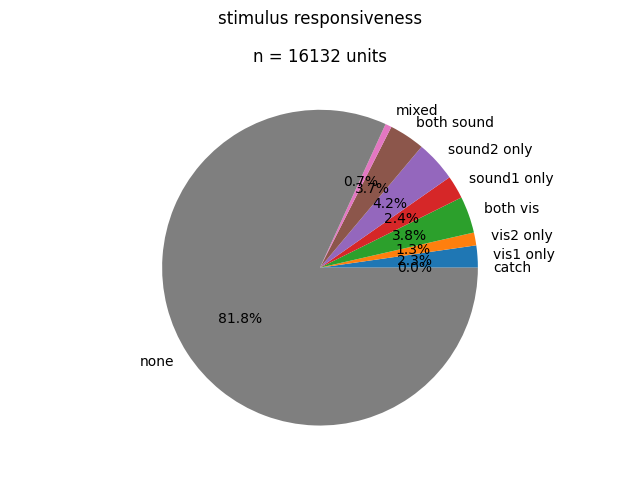

In [10]:
#plot overall stimulus modulation
plot_utils.plot_stimulus_modulation_pie_chart(adj_pvals,sel_project)

In [ ]:
#calculate stimulus modulation by region
area_fraction_responsive_to_stim = spike_utils.calculate_stimulus_modulation_by_area(sel_units,sel_project,plot_figures=False,savepath=None)

In [ ]:
#plot top 20 stimulus modulated regions

#stimulus:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#vis: vis1+vis1+both_vis
vis_resp=area_fraction_responsive_to_stim[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_responsive_to_stim['vis_only']=vis_resp
sort_by_vis=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='vis_only',ascending=False).head(20)
sort_by_vis[['area','vis_only']].plot.bar(ax=ax[0],x='area',y='vis_only',color='tab:blue')
ax[0].set_title('visual stimuli')
ax[0].set_ylabel('fraction of units responsive')

#aud: sound1+sound2+both_sound
aud_resp=area_fraction_responsive_to_stim[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_responsive_to_stim['aud_only']=aud_resp
sort_by_aud=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='aud_only',ascending=False).head(20)
sort_by_aud[['area','aud_only']].plot.bar(ax=ax[1],x='area',y='aud_only',color='tab:orange')
ax[1].set_title('auditory stimuli')
ax[1].set_ylabel('fraction of units responsive')

#mixed: mixed
sort_by_mixed=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='mixed',ascending=False).head(20)
sort_by_mixed[['area','mixed']].plot.bar(ax=ax[2],x='area',y='mixed',color='tab:green')
ax[2].set_title('multimodal')
ax[2].set_ylabel('fraction of units responsive')

fig.tight_layout()


In [ ]:
#plot top 20 stimulus modulated areas, including sign of modulation

#stimulus:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#vis: vis1+vis1+both_vis
vis_pos_resp=area_fraction_responsive_to_stim[['vis1_pos','vis2_pos','both_vis_pos']].sum(axis=1)
area_fraction_responsive_to_stim['vis_pos_only']=vis_pos_resp
vis_neg_resp=area_fraction_responsive_to_stim[['vis1_neg','vis2_neg','both_vis_neg']].sum(axis=1)
area_fraction_responsive_to_stim['vis_neg_only']=vis_neg_resp
vis_resp=area_fraction_responsive_to_stim[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_responsive_to_stim['vis_only']=vis_resp

sort_by_vis=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='vis_only',ascending=False).head(20)
sort_by_vis[['area','vis_pos_only','vis_neg_only']].plot.bar(ax=ax[0],x='area',stacked=True,color=['tab:blue','lightblue'])
ax[0].set_title('visual stimuli')
ax[0].set_ylabel('fraction of units responsive')
ax[0].legend(['positive','negative'])

#aud: sound1+sound2+both_sound
aud_pos_resp=area_fraction_responsive_to_stim[['sound1_pos','sound2_pos','both_sound_pos']].sum(axis=1)
area_fraction_responsive_to_stim['aud_pos_only']=aud_pos_resp
aud_neg_resp=area_fraction_responsive_to_stim[['sound1_neg','sound2_neg','both_sound_neg']].sum(axis=1)
area_fraction_responsive_to_stim['aud_neg_only']=aud_neg_resp
aud_resp=area_fraction_responsive_to_stim[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_responsive_to_stim['aud_only']=aud_resp

sort_by_aud=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='aud_only',ascending=False).head(20)
sort_by_aud[['area','aud_pos_only','aud_neg_only']].plot.bar(ax=ax[1],x='area',stacked=True,color=['tab:orange','bisque'])
ax[1].set_title('auditory stimuli')
ax[1].set_ylabel('fraction of units responsive')
ax[1].legend(['positive','negative'])

#mixed: mixed
mixed_pos_resp=area_fraction_responsive_to_stim[['mixed_pos']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_pos_only']=mixed_pos_resp
mixed_neg_resp=area_fraction_responsive_to_stim[['mixed_neg']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_neg_only']=mixed_neg_resp
mixed_resp=area_fraction_responsive_to_stim[['mixed']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_only']=mixed_resp

sort_by_mixed=area_fraction_responsive_to_stim.query('n_sessions_w_10_units>=3').sort_values(by='mixed',ascending=False).head(20)
sort_by_mixed[['area','mixed_pos_only','mixed_neg_only']].plot.bar(ax=ax[2],x='area',stacked=True,color=['tab:green','lightgreen'])
ax[2].set_title('multimodal')
ax[2].set_ylabel('fraction of units responsive')
ax[2].legend(['positive','negative'])

fig.tight_layout()


## context, stimulus, and lick modulation

In [ ]:
# #plot overall context, stim, lick modulation
plot_utils.plot_context_stim_lick_modulation_pie_chart(adj_pvals,sel_project)

In [ ]:
#calculate context, lick, stimulus modulation by region
area_fraction_context_mod=spike_utils.compute_context_stim_lick_modulation_by_area(sel_units,sel_project,plot_figures=False,savepath=None)

In [ ]:
#lick/context/stim:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#lick: any lick
sort_by_lick=area_fraction_context_mod.query('n_sessions_w_10_units>=3').sort_values(by='any_lick',ascending=False).head(20)
sort_by_lick[['area','any_lick']].plot.bar(ax=ax[0],x='area',y='any_lick',color='tab:purple')
ax[0].set_title('most lick responsive areas')
ax[0].set_ylabel('fraction of units responsive')

#context: any context
sort_by_context=area_fraction_context_mod.query('n_sessions_w_10_units>=3').sort_values(by='any_context',ascending=False).head(20)
sort_by_context[['area','any_context']].plot.bar(ax=ax[1],x='area',y='any_context',color='tab:brown')
ax[1].set_title('most context responsive areas')
ax[1].set_ylabel('fraction of units responsive')

#stim: any stim
sort_by_stim=area_fraction_context_mod.query('n_sessions_w_10_units>=3').sort_values(by='any_stim',ascending=False).head(20)
sort_by_stim[['area','any_stim']].plot.bar(ax=ax[2],x='area',y='any_stim',color='tab:blue')
ax[2].set_title('most stimulus responsive areas')
ax[2].set_ylabel('fraction of units responsive')


fig.tight_layout()

## context modulation of stimulus responses

In [ ]:
#plot stimulus responses modulated by context
plot_utils.plot_context_mod_stim_resp_pie_chart(adj_pvals,sel_project,savepath=None)

In [ ]:
sel_denominator='total_n'  # options: 'total_n', 'n_stim_responsive', 'n_late_stim_responsive'
area_fraction_context_stim_mod=spike_utils.calculate_context_mod_stim_resp_by_area(sel_units,sel_project,plot_figures=False,savepath=None,denominator=sel_denominator)

In [ ]:
# area_units=sel_units.query('structure=="PIR"')
# n_units=10
# area_units.groupby('session_id').filter(lambda x: len(x)>=n_units)['session_id'].unique()
# area_units['vis1_stimulus'


In [ ]:
#context modulation of stimulus
fig,ax=plt.subplots(1,1,figsize=(8,4))
#vis: vis1+vis2+both_vis
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_context_stim_mod['vis_only']=vis_context_stim_mod

#aud: sound1+sound2+both_sound
aud_context_stim_mod=area_fraction_context_stim_mod[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_context_stim_mod['aud_only']=aud_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim']=area_fraction_context_stim_mod[['vis1','vis2','sound1','sound2','mixed','both_vis','both_sound']].sum(axis=1)

sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query('n_sessions_w_5_units>=4 and not area.str.islower()').sort_values(by='any_stim',ascending=False).head(30)
sort_by_any_context_mod_stim[['area','vis_only','aud_only','mixed']].plot.bar(ax=ax,x='area',y=['vis_only','aud_only','mixed'],stacked=True)
ax.set_title('context modulation of stimulus responses; denominator='+sel_denominator)
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

In [ ]:
# #context modulation of evoked stimulus
# fig,ax=plt.subplots(3,1,figsize=(10,8))
# #vis: vis1+vis2+both_vis
# vis_context_evoked_stim_mod=area_fraction_context_stim_mod[['vis1_evoked','vis2_evoked','both_vis_evoked']].sum(axis=1)
# area_fraction_context_stim_mod['vis_only_evoked']=vis_context_evoked_stim_mod
# sort_by_vis_context_evoked_stim=area_fraction_context_stim_mod.query('n_sessions_w_10_units>=5').sort_values(by='vis_only_evoked',ascending=False).head(20)
# sort_by_vis_context_evoked_stim[['area','vis_only_evoked']].plot.bar(ax=ax[0],x='area',y='vis_only_evoked',color='tab:blue')
# ax[0].set_title('context modulation of evoked visual stim responses')
# ax[0].set_ylabel('fraction of units modulated')

# #aud: sound1+sound2+both_sound
# aud_context_evoked_stim_mod=area_fraction_context_stim_mod[['sound1_evoked','sound2_evoked','both_sound_evoked']].sum(axis=1)
# area_fraction_context_stim_mod['aud_only_evoked']=aud_context_evoked_stim_mod
# sort_by_aud_context_evoked_stim=area_fraction_context_stim_mod.query('n_sessions_w_10_units>=5').sort_values(by='aud_only_evoked',ascending=False).head(20)
# sort_by_aud_context_evoked_stim[['area','aud_only_evoked']].plot.bar(ax=ax[1],x='area',y='aud_only_evoked',color='tab:orange')
# ax[1].set_title('context modulation of evoked auditory stim responses')
# ax[1].set_ylabel('fraction of units modulated')

# #mixed: mixed
# sort_by_mixed_context_evoked_stim=area_fraction_context_stim_mod.query('n_sessions_w_10_units>=5').sort_values(by='mixed_evoked',ascending=False).head(20)
# sort_by_mixed_context_evoked_stim[['area','mixed_evoked']].plot.bar(ax=ax[2],x='area',y='mixed_evoked',color='tab:green')
# ax[2].set_title('context modulation of evoked multimodal stim responses')
# ax[2].set_ylabel('fraction of units modulated')

# fig.tight_layout()

In [ ]:
#context modulation of evoked stimulus responses
fig,ax=plt.subplots(1,1,figsize=(8,4))
#vis: vis1+vis2+both_vis
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1_evoked','vis2_evoked','both_vis_evoked']].sum(axis=1)
area_fraction_context_stim_mod['vis_only_evoked']=vis_context_stim_mod

#aud: sound1+sound2+both_sound
aud_context_stim_mod=area_fraction_context_stim_mod[['sound1_evoked','sound2_evoked','both_sound_evoked']].sum(axis=1)
area_fraction_context_stim_mod['aud_only_evoked']=aud_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim_evoked']=area_fraction_context_stim_mod[
    ['vis1_evoked','vis2_evoked','sound1_evoked','sound2_evoked','mixed_evoked','both_vis_evoked','both_sound_evoked']].sum(axis=1)

sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query(
    'n_sessions_w_5_units>=4 and not area.str.islower()').sort_values(by='any_stim_evoked',ascending=False).head(30)
sort_by_any_context_mod_stim[
    ['area','vis_only_evoked','aud_only_evoked','mixed_evoked']
    ].plot.bar(ax=ax,x='area',y=['vis_only_evoked','aud_only_evoked','mixed_evoked'],stacked=True)
ax.set_title('context modulation of evoked stimulus responses; denominator='+sel_denominator)
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

In [ ]:
#context modulation of late stimulus responses

fig,ax=plt.subplots(1,1,figsize=(8,4))
#vis: vis1+vis2+both_vis
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1_late','vis2_late','both_vis_late']].sum(axis=1)
area_fraction_context_stim_mod['vis_only_late']=vis_context_stim_mod

#aud: sound1+sound2+both_sound
aud_context_stim_mod=area_fraction_context_stim_mod[['sound1_late','sound2_late','both_sound_late']].sum(axis=1)
area_fraction_context_stim_mod['aud_only_late']=aud_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim_late']=area_fraction_context_stim_mod[
    ['vis1_late','vis2_late','sound1_late','sound2_late','mixed_late','both_vis_late','both_sound_late']].sum(axis=1)

sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query('n_sessions_w_5_units>=5 and not area.str.islower()').sort_values(by='any_stim_late',ascending=False).head(30)
sort_by_any_context_mod_stim[
    ['area','vis_only_late','aud_only_late','mixed_late']].plot.bar(
        ax=ax,x='area',y=['vis_only_late','aud_only_late','mixed_late'],stacked=True)
ax.set_title('context modulation of late stimulus responses; denominator='+sel_denominator)
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

In [ ]:
#context modulation of late stimulus responses

fig,ax=plt.subplots(1,1,figsize=(8,4))
#vis: vis1+vis2+both_vis
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1_late_evoked','vis2_late_evoked','both_vis_late_evoked']].sum(axis=1)
area_fraction_context_stim_mod['vis_only_late_evoked']=vis_context_stim_mod

#aud: sound1+sound2+both_sound
aud_context_stim_mod=area_fraction_context_stim_mod[['sound1_late_evoked','sound2_late_evoked','both_sound_late_evoked']].sum(axis=1)
area_fraction_context_stim_mod['aud_only_late_evoked']=aud_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim_late_evoked']=area_fraction_context_stim_mod[
    ['vis1_late_evoked','vis2_late_evoked','sound1_late_evoked','sound2_late_evoked',
     'mixed_late_evoked','both_vis_late_evoked','both_sound_late_evoked']].sum(axis=1)

sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query('n_sessions_w_5_units>=4 and not area.str.islower()').sort_values(by='any_stim_late_evoked',ascending=False).head(30)
sort_by_any_context_mod_stim[
    ['area','vis_only_late_evoked','aud_only_late_evoked','mixed_late_evoked']].plot.bar(
        ax=ax,x='area',y=['vis_only_late_evoked','aud_only_late_evoked','mixed_late_evoked'],stacked=True)
ax.set_title('context modulation of late evoked stimulus responses; denominator='+sel_denominator)
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

In [ ]:
# plot selected structures
#just visual responses
import numpy as np
sel_structures=['LGd','VISp','VISl','VISal','LP','VISrl','VISam','VISpm','ORBl','AId','MOs','FRP','CP','ACAd','SCs','SCm','MRN']

#context modulation of stimulus
fig,ax=plt.subplots(1,1,figsize=(5,3))
#any vis: vis1+vis2+both_vis+mixed
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1','vis2','both_vis','mixed']].sum(axis=1)
area_fraction_context_stim_mod['any_vis']=vis_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim']=area_fraction_context_stim_mod[['vis1','vis2','sound1','sound2','mixed','both_vis','both_sound']].sum(axis=1)

#sort by list order
sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query('n_sessions_w_5_units>=4 and not area.str.islower() and area in @sel_structures')
sort_by_any_context_mod_stim=sort_by_any_context_mod_stim.set_index('area').reindex(sel_structures).reset_index()

# #sort by any_vis
# sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query(
#     'n_sessions_w_5_units>=4 and not area.str.islower() and area in @sel_structures').sort_values(by='any_vis',ascending=True)

bars=sort_by_any_context_mod_stim[['area','any_vis']].plot.bar(ax=ax,x='area',y='any_vis',legend=False,color='k')

ax.set_title('context modulation of visual stimulus responses')
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

In [ ]:
# save figure
fig.savefig(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\v272_2025-08-15\context_modulation_of_visual_stim_responses_selected_areas_w_CP.pdf",dpi=300)

In [ ]:
sort_by_any_context_mod_stim

In [ ]:
#Layer diffs

In [ ]:
#RS vs FS

In [ ]:
#raw vs evoked context modulation

In [ ]:
#stim vs baseline context modulation

In [ ]:
sel_units.columns

In [ ]:
unit_counts=sel_units['structure'].value_counts()
unit_counts=unit_counts[unit_counts>=50]

fig,ax=plt.subplots(figsize=(12,6))
unit_counts.plot.bar(ax=ax)
fig.tight_layout()

In [ ]:
top_context_mod_stim_structures=['GPe','MRN','SNr','SNc','RN','NPC','VTA','SCm','RT','PAG','VM','ZI',
                                 'FRP','ACAd','VISrl','CP','VPL','MOs','VAL','APN','POL','AId','PCN',
                                 'CL','MD','Eth','AUDd','NOT','SSs','PL']

show_metric_name='stim_context_modulation_zscore'
stimuli=['vis1','vis2','sound1','sound2']

save_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\context_modulated_stimulus_response_example_PSTHs"

#loop through structures, find top 10 units by context modulation of stimulus response zscore, plot PSTHs
for structure in top_context_mod_stim_structures:
    area_units=sel_units.query('structure==@structure')

    area_units['max_context_mod_stim_zscore']=area_units[['vis1_context_modulation_zscore',
                                                  'vis2_context_modulation_zscore',
                                                  'sound1_context_modulation_zscore',
                                                  'sound2_context_modulation_zscore']].abs().max(axis=1)
    
    area_units['min_context_mod_stim_p_value']=area_units[['vis1_context_modulation_p_value',
                                                    'vis2_context_modulation_p_value',
                                                    'sound1_context_modulation_p_value',
                                                    'sound2_context_modulation_p_value']].min(axis=1)

    top_units=area_units.query(
        'min_context_mod_stim_p_value<0.001'
        ).sort_values(by='max_context_mod_stim_zscore', ascending=False).head(10)

    for unit_id in top_units['unit_id'].unique():
        # plot_utils.plot_unit_response_by_context_modulation(unit_id,savepath=None)
        # plot_utils.plot_unit_response_by_task_performance_stim_aligned(unit_id)
        metric_values_dict={}
        for ss in stimuli:
            metric_values_dict[ss]=top_units.query('unit_id==@unit_id')[show_metric_name.replace('stim',ss)].values[0]
        plot_utils.plot_unit_by_id(unit_id, save_path=save_path,)
        # break

    # break


In [ ]:
# plot vis pathway units example PSTHs

# filter by responsiveness to vis1 or vis2, get both modulated and non modulated examples

metric_1_name = 'stim_stimulus_modulation_p_value'

metric_2_name = 'stim_context_modulation_p_value'

stimuli=['vis1','vis2']

vis_pathway_structures=['LGd','LP','VISp','VISl','VISal','VISpm','VISam','VISrl']

non_mod_save_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\not_context_modulated_stimulus_response_example_PSTHs"

#loop through structures, find top 10 units by context modulation of stimulus response zscore, plot PSTHs
for structure in vis_pathway_structures:
    area_units=sel_units.query('structure==@structure')

    area_units['max_context_mod_stim_zscore']=area_units[['vis1_context_modulation_zscore',
                                                  'vis2_context_modulation_zscore']].abs().max(axis=1)
    
    area_units['min_context_mod_stim_p_value']=area_units[['vis1_context_modulation_p_value',
                                                    'vis2_context_modulation_p_value']].min(axis=1)

    top_units=area_units.query(
        'min_context_mod_stim_p_value<0.001 and (vis1_stimulus_modulation_p_value<0.01 or vis2_stimulus_modulation_p_value<0.01)'
        ).head(10)
    
    non_mod_units=area_units.query(
        'min_context_mod_stim_p_value>0.5 and (vis1_stimulus_modulation_p_value<0.01 or vis2_stimulus_modulation_p_value<0.01)'
        ).head(10)

    for unit_id in top_units['unit_id'].unique():
        # metric_values_dict={}
        # for ss in stimuli:
        #     metric_values_dict[ss]=top_units.query('unit_id==@unit_id')[metric_1_name.replace('stim',ss)].values[0]
        plot_utils.plot_unit_by_id(unit_id, save_path=save_path,)
        # break

    for unit_id in non_mod_units['unit_id'].unique():
        # metric_values_dict={}
        # for ss in stimuli:
        #     metric_values_dict[ss]=non_mod_units.query('unit_id==@unit_id')[show_metric_name.replace('stim',ss)].values[0]
        plot_utils.plot_unit_by_id(unit_id, save_path=non_mod_save_path,)
        # break

    # break

In [ ]:
# plot_utils.plot_unit_response_by_task_performance_stim_aligned()